# FINE TUNING

Obiettivo di questo notebook è verificare come effettuare fine tuning del GPT pre-trained con i weights di OPENAI con 2 diversi obiettivi:
- classification fine tuning : serve per categorizzare i dati in input tra diverse classi pre-definite
- instruction fine tuning : serve per far si che il modello sia in grado di capire e generare risposte a fronte di istruzioni impartite per mezzo di un prompt

Il secondo caso richiede molte più risorse rispetto al primo


## Classification fine tuning

Primo step è sempre quello di preparare un dataset. <br>
Nel nostro caso utilizziamo un dataset di messaggi di testo che dovranno essere classificati in spam o non-spam.

In [53]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"


def download_and_unzip_spam_data(
        url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download "
              "and extraction."
        )
        return

    # Downloads the file
    with urllib.request.urlopen(url) as response:   
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzips the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:    
        zip_ref.extractall(extracted_path)

    original_file_path = Path(extracted_path) / "SMSSpamCollection"

    # Adds a .tsv file extension 
    os.rename(original_file_path, data_file_path)               
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


Importo il dataset in un pandas dataframe

In [54]:
import pandas as pd

df = pd.read_csv(
    data_file_path, sep="\t", header=None, names=["Label", "Text"]
)
df    

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


E' possibile verificare che la distribuzione delle classi è sbilanciata

In [55]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


Per bilanciare il dataset effettuo undersample della classe più numerosa

In [56]:
def create_balanced_dataset(df):

    # Counts the instances of “spam” 
    num_spam = df[df["Label"] == "spam"].shape[0]    
    
    # Randomly samples “ham” instances to match the number of “spam” instances 
    ham_subset = df[df["Label"] == "ham"].sample(
        num_spam, random_state=123
    )                                         
    
    #  Combines ham subset with “spam” 
    balanced_df = pd.concat([
        ham_subset, df[df["Label"] == "spam"]
    ])                               #3
    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


Infine convertiamo le 2 labels da formato testo a integer class labels

In [57]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

In [58]:
balanced_df

,Label,Text
4307,0,Awww dat is sweet! We can think of something t...
4138,0,Just got to &lt;#&gt;
4831,0,"The word ""Checkmate"" in chess comes from the P..."
4461,0,This is wishing you a great day. Moji told me ...
5440,0,Thank you. do you generally date the brothas?
...,...,...
5537,1,Want explicit SEX in 30 secs? Ring 02073162414...
5540,1,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,1,Had your contract mobile 11 Mnths? Latest Moto...
5566,1,REMINDER FROM O2: To get 2.50 pounds free call...


Infine splittiamo il dataset in train, validation e test

In [59]:
def random_split(df, train_frac, validation_frac):

    # Shuffles the entire DataFrame 
    df = df.sample(
        frac=1, random_state=123
    ).reset_index(drop=True)              
    
    #  Calculates split indices 
    train_end = int(len(df) * train_frac)         
    
    validation_end = train_end + int(len(df) * validation_frac)

    # Splits the DataFrame 
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

# Test size is implied to be 0.2 as the remainder
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)                    

Infine esportiamo i 3 dataframe ottenuti in formato csv

In [61]:
train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## Dataloaders

Dal momento che i messaggi sono di diversa lunghezza ho 2 possibilità:
- troncare i messaggi alla dimensione del più corto del dataset o del batch
- effettuare il padding alla lunghezza del più lungo

Optiamo x la seconda possibilità aggiungendo padding token ai messaggi più corti. Aggiungiamo quindi direttamente il tokenid corrispondete a "<|endoftext|>"

In [62]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))


[50256]


Prima di creare il dataloader è necessario creare il Pytorch Dataset che specifica come i dati sono caricati e processati.<br>
La classe SpamDataset:
- identifica il messaggio più lungo
- fa encode dei messaggi di testo
- effettua padding dei messaggi più corti aggiungendo i token <|endoftext|> 

In modo che tutti gli input tensor siano della stessa lunghezza

In [63]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):

    # Pretokenizes texts 
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        
        self.data = pd.read_csv(csv_file)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        # Truncates sequences if they are longer than max_length
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length

            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # Pads sequences to the longest sequence 
        self.encoded_texts = [
            encoded_text + [pad_token_id] * 
            (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]


    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [64]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

In [65]:
print(train_dataset.max_length)

120


Dal momento che il modello supporta context size di 1024 tokens, non c'è problema. Se ci fossero messaggi più lunghi sarebbe necessario settare max_lenght=1024

In [66]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

E' ora possibile creare i dataloader utilizzando Pytorch DataLoader

In [67]:
from torch.utils.data import DataLoader

# This setting ensures compatibility with most computers. 
num_workers = 0     
batch_size = 8
torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

In [68]:
for input_batch, target_batch in train_loader:
    pass
print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


In [69]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


Prima di iniziare il classification fine tuning è necessario inizializzare il modello con i pretrained weights di OpenAI 
come fatto nel precedente notebook con unlabelled data

In [70]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"
BASE_CONFIG = {
    "vocab_size": 50257,          #1
    "context_length": 1024,       #2
    "drop_rate": 0.0,             #3
    "qkv_bias": True              #4
}
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}
BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

Copio dal notebook precedente tutti i moduli che compongono GPTModel e la funzione load_weights_into_gpt

In [71]:
import torch
import torch.nn as nn

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift
        
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))
        
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec
 
class TransformerBlock(nn.Module):
    
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):

        # Shortcut connection for attention block 
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)

        # Add the original input back 
        x = x + shortcut      

        # Shortcut connection for feed forward block 
        shortcut = x         
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)

        
        x = x + shortcut      
        return x

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        # The device setting will allow us to train the model on a CPU or GPU, depending on which device the input data sits on
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, "
                          "Right: {right.shape}"
        )
    return torch.nn.Parameter(torch.tensor(right))

import numpy as np

# Sets the model’s positional and token embedding weights to those specified in params. 
def load_weights_into_gpt(gpt, params):          
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    # Iterates over each transformer block in the model 
    for b in range(len(params["blocks"])):    

        # The np.split function is used to divide the attention and bias weights 
        # into three equal parts for the query, key, and value components. 
        q_w, k_w, v_w = np.split(                           
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])

    # The original GPT-2 model by OpenAI reused the token embedding weights in the output layer
    # to reduce the total number of parameters, which is a concept known as weight tying. 
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])    

In [72]:
from gpt_download import download_and_load_gpt2

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


2025-04-01 16:27:59.579765: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 154389504 exceeds 10% of free system memory.


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Copio anche le funzioni dei notebook precedenti al fine di generare testo

In [73]:
import tiktoken


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)    #1
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)                #2
    return tokenizer.decode(flat.tolist())

def generate_text_simple(model, 
                         idx,        # idx is a (batch, n_tokens) array of indices in the current context. 
                         max_new_tokens,
                         context_size): 
    for _ in range(max_new_tokens):

        # Crops current context if it exceeds the supported context size,
        # e.g., if LLM supports only 5 tokens, and the context size is 10, then only the last 5 tokens are used as context 
        idx_cond = idx[:, -context_size:]   
        with torch.no_grad():
            logits = model(idx_cond)

        # Focuses only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size) 
        logits = logits[:, -1, :]                    
        # probas has shape (batch, vocab_size). 
        probas = torch.softmax(logits, dim=-1)          
        # idx_next has shape (batch, 1). 
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)   
        # Appends sampled index to the running sequence, where idx has shape (batch, n_tokens+1) 
        idx = torch.cat((idx, idx_next), dim=1)    

    return idx

Infine verifico se il modello pretrained è in grado di produrre testo coerente

In [74]:
text_1 = "Every effort moves you"
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))


Every effort moves you forward.

The first step is to understand the importance of your work


Dopo aver verificato che il modello è in grado di generare contenuti testuali coerenti, provo a verificare la sua capacità di classificare un testo

In [75]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
)
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)
print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

The following text 'spam'? Answer with 'yes' or 'no': 'You are a winner


Ovviamente allo stato attuale non è ancora in grado di fare l'attività di classificazione.<br>
Per far ciò è necessario procedere ad aggiungere un <b>CLASSIFICATION HEAD</B> al posto dell'attuale output layer.

Il nuovo output layer dovrà mappare la rappresentazione dell'LLM (hidden layer di 768 units) sulle 2 possibili classi di output (SPAM/NO SPAM)

Come primo step procediamo a rendere non trainable i weights del modello pretrained

In [76]:
for param in model.parameters():
    param.requires_grad = False

e sostituiamo l'output layer originale con quello adatto per la classificazione binaria

In [77]:
torch.manual_seed(123)
num_classes = 2
model.out_head = torch.nn.Linear(
    in_features=BASE_CONFIG["emb_dim"], 
    out_features=num_classes
)

Tecnicamente questo layer è l'unico di cui dovrebbe essere fatto il training ma è stato rilevato che, per migliorare le prestazioni, è opportuno effettuare il training anche dei layer più esterni (ultimo transformer block + Layernorm)

In [78]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True
for param in model.final_norm.parameters():
    param.requires_grad = True

Il modello si aspetta sempre un input dello stesso formato precedente

In [83]:
inputs = tokenizer.encode("Do you have time")

# converto la lista in tensor e aggiungo la dimensione del batch
inputs = torch.tensor(inputs).unsqueeze(0) 
print("Inputs:", inputs)

# shape: (batch_size, num_tokens) 
print("Inputs dimensions:", inputs.shape)   

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


..e questo input può essere passato al modello come prima

In [81]:
with torch.no_grad():
    outputs = model(inputs)
print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


Dal momento che l'obiettivo del modello è classificare la sequenza di input in una delle 2 classi, è sufficiente effettuare il fine tuning solo sull'ultimo output token che, dal momento che viene utilizzata causal attention, è il token che raggruppa informazioni su tutti i token presenti in input.

In [85]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


Per convertire questi token nella previsione SPAM o NO SPAM si utilizza lo stesso approccio utilizzato per il pre-training: si converte questi token nelle corrispondenti probabilità utilizzando la funzione softmax e si sceglie quello con probabilità più alta.

In [88]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


Prima di poter effettuare il fine tuning è però necessario implementare la funzione di valutazione del modello da utilizzare durante il fine tuning

In [89]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)


            with torch.no_grad():

                # Logits of last output token 
                logits = model(input_batch)[:, -1, :]     
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (
                (predicted_labels == target_batch).sum().item()
            )

        else:
            break
    return correct_predictions / num_examples

Possiamo testa la funzione per calcolare l'accuracy prendendo 10 batch random per i 3 dataset.<br>
Ovviamente, essendo in modello non ancora fine-tuned, i risultati sono random

In [90]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

torch.manual_seed(123)
train_accuracy = calc_accuracy_loader(
    train_loader, model, device, num_batches=10
)
val_accuracy = calc_accuracy_loader(
    val_loader, model, device, num_batches=10
)
test_accuracy = calc_accuracy_loader(
    test_loader, model, device, num_batches=10
)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


Dal momento che accuracy non è differenziabile, dobbiamo calcolare cross-entropy come funzione sostitutiva per massimizzare l'accuracy. A differenza di cross-entropy calcolata per il pre-trainig però, in questo caso dobbiamo ottimizzare solo l'ultimo token.

DEfinisco la funzione per calcolare loss per un singolo batch

In [91]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)
    target_batch = target_batch.to(device)
    logits = model(input_batch)[:, -1, :]     #1
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

E per calcolare loss per tutti i batch restituiti dal dataloader

In [93]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)

    # Ensures number of batches doesn’t exceed batches in data loader 
    else:                                        
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

Calcoliamo loss iniziale per ciascun data set

In [94]:
with torch.no_grad():                 #1
    train_loss = calc_loss_loader(
        train_loader, model, device, num_batches=5
    )
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)
print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")


Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


E' ora possibile fare il training del modello al fine di minimizzare il training loss (e massimizzare accuracy)

In [95]:
def train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs, eval_freq, eval_iter):
    
    # Initialize lists to track losses and examples seen 
    train_losses, val_losses, train_accs, val_accs = [], [], [], []   
    examples_seen, global_step = 0, -1

    #  Main training loop 
    for epoch in range(num_epochs):    
        #  Sets model to training mode 
        model.train()            

        for input_batch, target_batch in train_loader:
            #  Resets loss gradients from the previous batch iteration 
            optimizer.zero_grad()                     
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            # Calculates loss gradients 
            loss.backward()                          
            # Updates model weights using loss gradients 
            optimizer.step()                          
            # New: tracks examples instead of tokens 
            examples_seen += input_batch.shape[0]    
            global_step += 1

            # Optional evaluation step 
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, "
                      f"Val loss {val_loss:.3f}"
                )

        # Calculates accuracy after each epoch 
        train_accuracy = calc_accuracy_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_accuracy = calc_accuracy_loader(
            val_loader, model, device, num_batches=eval_iter
        )

        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

Evaluate model è identico al pre-training

In [97]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

E' ora possibile fare il fine tuning

In [98]:
import time

start_time = time.time()
torch.manual_seed(123)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)
num_epochs = 5


train_losses, val_losses, train_accs, val_accs, examples_seen = \
    train_classifier_simple(
        model, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=50,
        eval_iter=5
    )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 1.977, Val loss 2.196
Ep 1 (Step 000050): Train loss 0.615, Val loss 0.636
Ep 1 (Step 000100): Train loss 0.520, Val loss 0.555
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.563, Val loss 0.488
Ep 2 (Step 000200): Train loss 0.418, Val loss 0.395
Ep 2 (Step 000250): Train loss 0.408, Val loss 0.352
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.330, Val loss 0.314
Ep 3 (Step 000350): Train loss 0.278, Val loss 0.181
Training accuracy: 90.00% | Validation accuracy: 92.50%
Ep 4 (Step 000400): Train loss 0.076, Val loss 0.131
Ep 4 (Step 000450): Train loss 0.125, Val loss 0.099
Ep 4 (Step 000500): Train loss 0.202, Val loss 0.102
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.206, Val loss 0.110
Ep 5 (Step 000600): Train loss 0.067, Val loss 0.056
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 7.82 mi

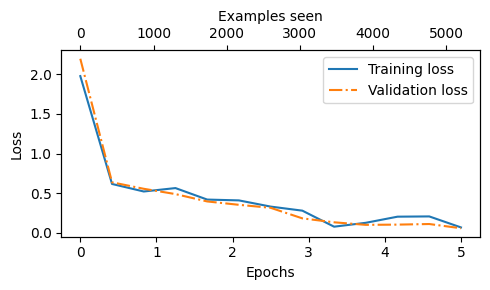

In [99]:
import matplotlib.pyplot as plt

def plot_values(
        epochs_seen, examples_seen, train_values, val_values,
        label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

 #1
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(
        epochs_seen, val_values, linestyle="-.",
        label=f"Validation {label}"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

 #2
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)    #3
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()             #4
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

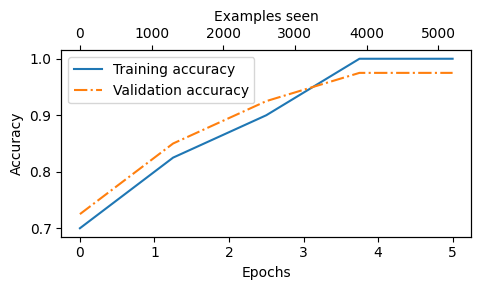

In [100]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(
    epochs_tensor, examples_seen_tensor, train_accs, val_accs,
    label="accuracy"
)

In [101]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.60%
Validation accuracy: 97.32%
Test accuracy: 96.00%


Una volta concluso il fine-tuning è possibile procedere con la classificazione dei messaggi tra SPAM e NO SPAM utilizzando il modello fine-tuned

In [103]:
def classify_review(
        text, model, tokenizer, device, max_length=None,
        pad_token_id=50256):
    model.eval()

    # Prepares inputs to the model 
    input_ids = tokenizer.encode(text)          
    supported_context_length = model.pos_emb.weight.shape[1]

    #  Truncates sequences if they are too long 
    input_ids = input_ids[:min(              
        max_length, supported_context_length
    )]

    # Pads sequences to the longest sequence 
    input_ids += [pad_token_id] * (max_length - len(input_ids))    

    # Adds batch dimension 
    input_tensor = torch.tensor(
        input_ids, device=device
    ).unsqueeze(0)              

    # Models inference without gradient tracking 
    with torch.no_grad():                                
        logits = model(input_tensor)[:, -1, :]     # Logits of the last output token 
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Returns the classified result 
    return "spam" if predicted_label == 1 else "not spam"     #

In [104]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [105]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))


not spam


Una volta testato che il modello funziona correttamente è possibile procedere con il salvataggio del modello

In [106]:
torch.save(model.state_dict(), "review_classifier.pth")

Una volta salvato il modello può essere caricato

In [108]:
model_state_dict = torch.load("review_classifier.pth", map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>